In [216]:
import openmeteo_requests
import matplotlib.pyplot as plt
import requests_cache
import pandas as pd
import numpy as np
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from retry_requests import retry
from matplotlib.dates import DateFormatter, DayLocator

In [186]:
def call_open_meteo_max(selected_station, start, end):
    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession(".cache", expire_after=-1)
    retry_strategy = Retry(total=5, backoff_factor=0.2)
    adapter = HTTPAdapter(max_retries=retry_strategy)
    cache_session.mount('http://', adapter)
    cache_session.mount('https://', adapter)
    openmeteo = openmeteo_requests.Client(session=cache_session)

    # Initialize an empty list to store daily data
    daily_data = []

    # Define the start and end dates for the loop
    start_date = pd.Timestamp(start)
    end_date = pd.Timestamp(end)

    # Iterate through each day of December
    while start_date <= end_date:
        # Define the parameters for the API call
        params = {
            "latitude": selected_station["lat"],
            "longitude": selected_station["lon"],
            "start_date": start_date.strftime("%Y-%m-%d"),
            "end_date": start_date.strftime("%Y-%m-%d"),  # Use the same start and end date for daily data
            "daily": "wind_speed_10m_max",
            "timezone": "Europe/Berlin",
        }

        # Make the API call
        responses = openmeteo.weather_api("https://archive-api.open-meteo.com/v1/archive", params=params)

        for response in responses:
            # Process daily data. The order of variables needs to be the same as requested.
            daily = response.Daily()
            daily_wind_speed_10m_max = daily.Variables(0).ValuesAsNumpy()

            # Calculate the average wind speed for the day
            max_wind_speed = daily_wind_speed_10m_max.max()

            # Append the average wind speed for the day to daily_data
            daily_data.append({
                "date": start_date.strftime('%Y-%m-%d'),  # Format date to include year, month, and day
                "wind_speed_10m_max": max_wind_speed,  # Use the average wind speed
            })

        # Move to the next day
        start_date += pd.Timedelta(days=1)

    # Create a DataFrame from daily data
    daily_dataframe = pd.DataFrame(daily_data)
    
    # Calculate daily averages
    daily_max = daily_dataframe.groupby('date').max()
    return daily_max

In [187]:
def call_open_meteo_temp(selected_station, start, end):
    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession(".cache", expire_after=-1)
    retry_strategy = Retry(total=5, backoff_factor=0.2)
    adapter = HTTPAdapter(max_retries=retry_strategy)
    cache_session.mount('http://', adapter)
    cache_session.mount('https://', adapter)
    openmeteo = openmeteo_requests.Client(session=cache_session)

    # Initialize an empty list to store daily data
    daily_data = []

    # Define the start and end dates for the loop
    start_date = pd.Timestamp(start)
    end_date = pd.Timestamp(end)

    # Iterate through each day of December
    while start_date <= end_date:
        # Define the parameters for the API call
        params = {
            "latitude": selected_station["lat"],
            "longitude": selected_station["lon"],
            "start_date": start_date.strftime("%Y-%m-%d"),
            "end_date": start_date.strftime("%Y-%m-%d"),  # Use the same start and end date for daily data
            "daily": "temperature_2m_mean",
            "timezone": "Europe/Berlin",
        }

        # Make the API call
        responses = openmeteo.weather_api("https://archive-api.open-meteo.com/v1/archive", params=params)

        for response in responses:
            # Process daily data. The order of variables needs to be the same as requested.
            daily = response.Daily()
            daily_temp_mean = daily.Variables(0).ValuesAsNumpy()

            # Calculate the average wind speed for the day
            avg_wind_speed = daily_temp_mean.mean()

            # Append the average wind speed for the day to daily_data
            daily_data.append({
                "date": start_date.strftime('%Y-%m-%d'),  # Format date to include year, month, and day
                "temperature_2m_mean": avg_wind_speed,  # Use the average wind speed
            })

        # Move to the next day
        start_date += pd.Timedelta(days=1)

    # Create a DataFrame from daily data
    daily_dataframe = pd.DataFrame(daily_data)
    
    # Calculate daily averages
    daily_avg = daily_dataframe.groupby('date').mean()
    return daily_avg

In [188]:
Deutschland_Berlin={'lat': 52.5200, 'lon': 13.4050}
Deutschland_Berlin_wind_Lothar = call_open_meteo_max(Deutschland_Berlin, "1999-12-20", "1999-12-31")
Deutschland_Berlin_wind_2000 = call_open_meteo_max(Deutschland_Berlin, "2000-12-20", "2000-12-31")
Deutschland_Berlin_temp_Lothar = call_open_meteo_temp(Deutschland_Berlin, "1999-12-20", "1999-12-31")

In [242]:
Deutschland_Frankfurt = {'lat': 50.110924, 'lon': 8.682127}
Deutschland_Frankfurt_wind_Lothar = call_open_meteo_max(Deutschland_Frankfurt, "1999-12-20", "1999-12-31")
Deutschland_Frankfurt_wind_2000 = call_open_meteo_max(Deutschland_Frankfurt, "2000-12-20", "2000-12-31")
Deutschland_Frankfurt_temp_Lothar = call_open_meteo_temp(Deutschland_Frankfurt, "1999-12-20", "1999-12-31")

In [240]:
def plot_windmax_compare(Wind_lothar, Wind_other, Ortschaft):
    # Synchronisieren der Indexe der beiden Datenrahmen
    Wind_other = Wind_other.set_index(Wind_lothar.index)
    other_year = Wind_other.index[0][:4]  # Extrahiere die ersten vier Zeichen, die das Jahr darstellen
    data = pd.concat([Wind_lothar, Wind_other], axis=1)
    data.columns = ['Sturm Lothar (1999)', f'Vergleichsjahr ({other_year})']
        
    # Plot
    ax = data.plot(kind='line', figsize=(30, 6), linewidth=5, color=['red', 'darkblue'])
    # Beschriftungen und Anpassungen
    plt.xlabel('Datum')
    plt.ylabel('Wind in m/s')
    plt.suptitle(Ortschaft, fontsize=14, fontweight='bold')
    plt.title(f'Wind Vergleich während Lothar (1999) und dem Jahr {other_year}')
    
    plt.legend(loc='upper left')
    plt.grid(False)
    # Plot-Begrenzungen oben und rechts entfernen
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Datumsformat auf der X-Achse anpassen
    #ax.xaxis.set_major_locator(DayLocator())
    #ax.xaxis.set_major_formatter(DateFormatter('%d'))
    plt.show()

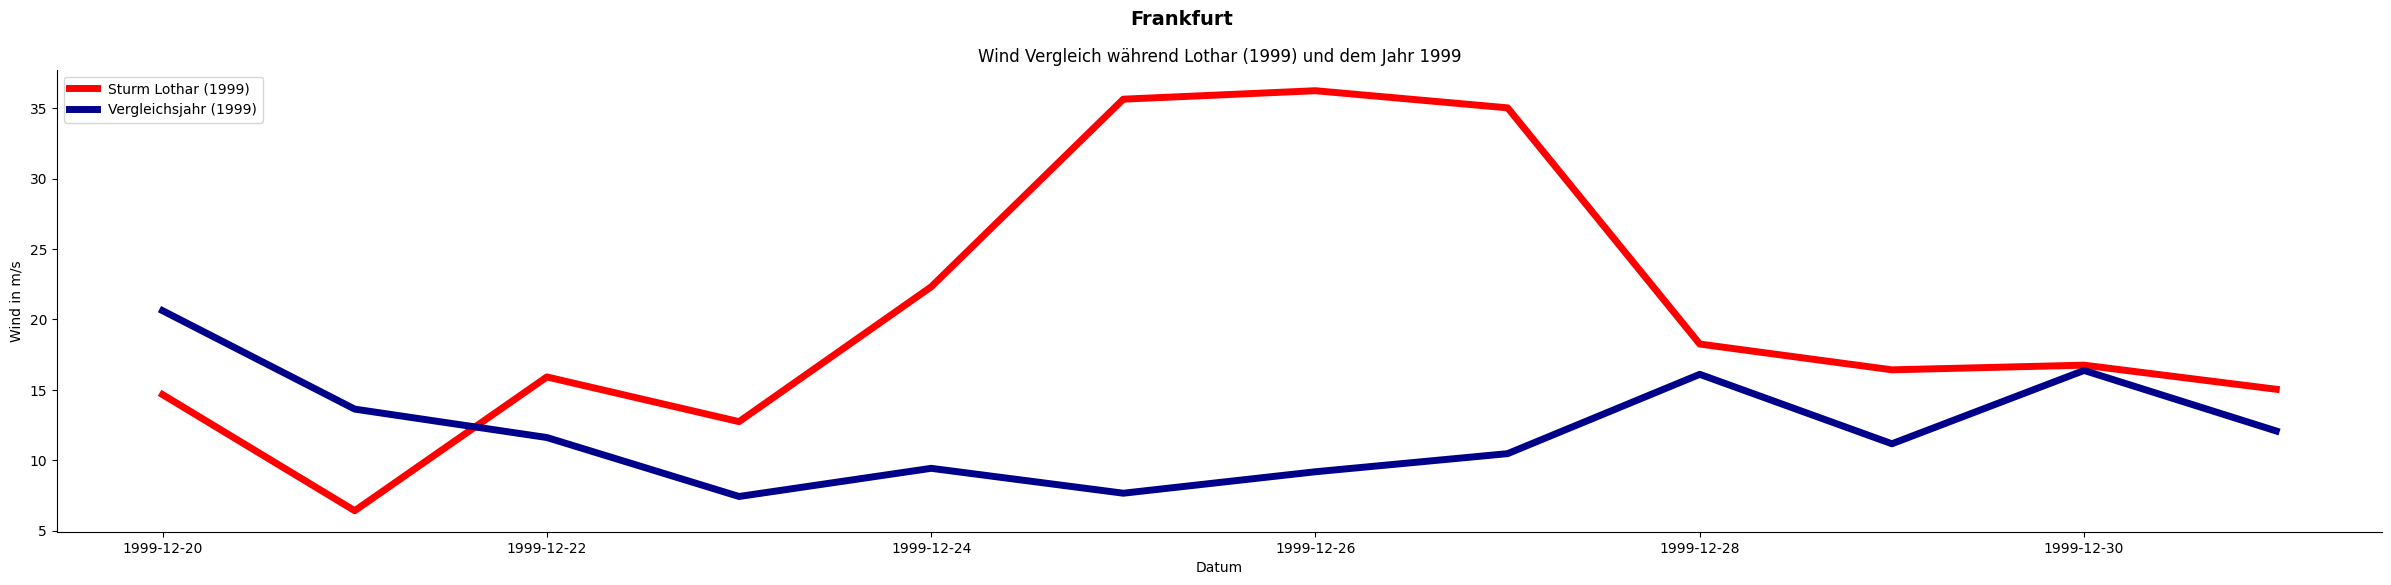

In [243]:
plot_windmax_compare(Deutschland_Frankfurt_wind_Lothar, Deutschland_Frankfurt_wind_2000, "Frankfurt")